In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_GiuaKy'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_GiuaKy


In [ ]:
!pip install pandas-profiling==2.7.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pandas_profiling as pp
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('dataset_2190_cholesterol.csv', na_values='?')
data.head()

,age,sex,cp,trestbps,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,chol
0,63,1,1,145,1,2,150,0,2.3,3,0.0,6.0,0,233
1,67,1,4,160,0,2,108,1,1.5,2,3.0,3.0,2,286
2,67,1,4,120,0,2,129,1,2.6,2,2.0,7.0,1,229
3,37,1,3,130,0,0,187,0,3.5,3,0.0,3.0,0,250
4,41,0,2,130,0,2,172,0,1.4,1,0.0,3.0,0,204


In [5]:
profile = pp.ProfileReport(data)
profile

Output hidden; open in https://colab.research.google.com to view.

**Phân tích dữ liệu:**
- Có tổng cộng 303 mẫu
- Có tổng cộng 13 biến input và 1 output (chol)
- Có 6 missing values, vì số lượng khá ít nên có thể sử dụng KNN imputer để xử lý
- Có 9 biến input categorical đều đã được convert sang numerical: sex, cp, fbs, restecg, exang, slope, ca, thal, num.
- 4 biến input numerical: age, trestbps, thalach, oldpeak có range min-max khác nhau nên tiến hành scale trước khi đưa vào model.

**Phân tích tương quan với biến output (chol):**
- So sánh với tương quan biến output, dựa trên correlation matrix, chỉ có 1 vài biến có mối tương quan trung bình với chol: ca, restecg, trestbps, sex, age.
- Vì chỉ có 303 mẫu, mà có đến 13 biến input, phần lớn trong đó là categoric, đồng thời rất ít biến thật sự có mối tương quan với output (chol), và nếu có thì tương quan rất yếu, nên bài toán này dự kiến sẽ có 2 vấn đề lớn:
    - **Underfiting**: Vì các features có quá ít mối tương quan với output
    - **Overfiting**: Vì tỉ lệ 303 mẫu - 13 features, đồng thời nếu chuyển sang on-hot encoder sẽ tăng lên rất nhiều, nên model rất dễ train bằng memorizing mà sẽ không generalize được trên test set --> Overfitting

- Để tiến hành **xử lý Underfiting**, có thể dùng các cách sau:
    - Làm tăng (enrich) các giá trị bằng cách tăng bậc (Polynominal) cho các input.
    - Sử dụng các model regression mạnh như SVM với kernel poly hay rbf. 
    - Có thể sử dụng các thuật toán ensemble như RandomForest hay Boosting, vì thuật toán Tree có tính chất có thể chia nhỏ nhất đến từng trường hợp mẫu nên xử lý được underfiting, tuy nhiên rất dễ bị Overfitting. Kết hợp nhiều Trees như RandomForest, Boosting giúp làm giảm Overfitting.
    - Một cách khác để làm tăng giá trị các biến (enrich features) là sử dụng Multilayer Perceptron (theo cách xưa cũ) hay Multi Dense Layer của Deep Learning (hiện đại). Qua nhiều layers, các input sẽ kết hợp với nhau tạo ra nhiều giá trị hơn là single shalow layer của input trong model machine learning. Tuy nhiên cách này rất dễ bị overfitting vì số lượng mẫu rất ít.
    - Nếu thực hiện các cách trên không được, ta có thể dùng unsupervised learning để phân nhóm biến output, dùng kết quả chỉ ra parameter của các input phân loại. Rồi tiến hành regression dựa trên từng nhóm, và tổng hợp kết quả.

- Để tiến hành **xử lý Overrfiting**, có thể dùng các cách sau:
    - Chọn features trước khi đưa vào model: Dùng SelectKBest, Corr Matrix hay ImportanceFeature của Decision Tree. Việc giảm features đưa vào model sẽ giúp giảm Overfiting. Cũng có thể lựa chọn features bằng PCA.
    - Sử dụng các Regularized như Ridge, Lasso. Nếu sử dụng Neuron Net thì dùng Dropout, Batchnorm, Weight-decay

Các models có thể sử dụng cho Regression:
- Linear Regression
- Polynorminal Regression (degree=2 or 3)
- SVM linear, SVM poly (2,3), SVM rbf
- Random Forest, AdaBoost, XGBoost

Về cách evaluation model:
- Vì đây là data set nhỏ và chỉ bao gồm 1 data, không tách biệt ngay từ ban đầu train-test set, nên có 2 cách để evaluate model:
    - **Cách 1:** Chia data thành **train-test set**, tiến hành train model trên **train data**, tunning hyper-parameter bằng Cross-validation hay Grid trên **train data**, chọn model có test-cross_validation r2 tốt nhất. Sau đó đem model test kết quả trên **test data**, để xem model có thể dự đoán tốt trên dữ liệu chưa từng thấy hay không.
    - **Cách 2:** **Không chia data thành train-test set** vì số lượng mẫu khá nhỏ, chạy **cross-validation xem kết quả trên full X, y**, đồng thời tunning hyper-parameter bằng cross-validation, sau đó chọn model có test-cross_validation r2 tốt nhất. Với model tìm được, hi vọng model vẫn có thể dự đoán tốt trên dữ liệu chưa từng thấy trong tương lai.
- Ở bài toán này, ta xây dựng cách evaluation theo **Cách 1**.

Các bước thực hiện:
- Sử dụng KNNImputer để filling missing values.
- Vẽ distribution và boxplot để xem các biến numerical nên sử dụng scaler nào, tiến hành scale các biến numerical.
- Split train - test split
- Tiến hành SelectKbest hay FeatureImportance của Random Forest hay PCA để chọn các biến có tương quan tốt nhất tiến hành Features Selection.
- Dựng thêm option convert One-hot encoding với các biến categorical.
- Tổng hợp các models đã liệt kê bên trên vào 1 list, hyper-parameter để default.
- Viết function chạy Cross-validation 5-folds cho list models, xem kết quả ban đầu các models nào có hiệu quả cao, models nào hiệu quả thấp

In [6]:
# Sử dụng KNNImputer để filling missing values.
from sklearn.impute import KNNImputer
imputer = KNNImputer()
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   fbs       303 non-null    float64
 5   restecg   303 non-null    float64
 6   thalach   303 non-null    float64
 7   exang     303 non-null    float64
 8   oldpeak   303 non-null    float64
 9   slope     303 non-null    float64
 10  ca        303 non-null    float64
 11  thal      303 non-null    float64
 12  num       303 non-null    float64
 13  chol      303 non-null    float64
dtypes: float64(14)
memory usage: 33.3 KB


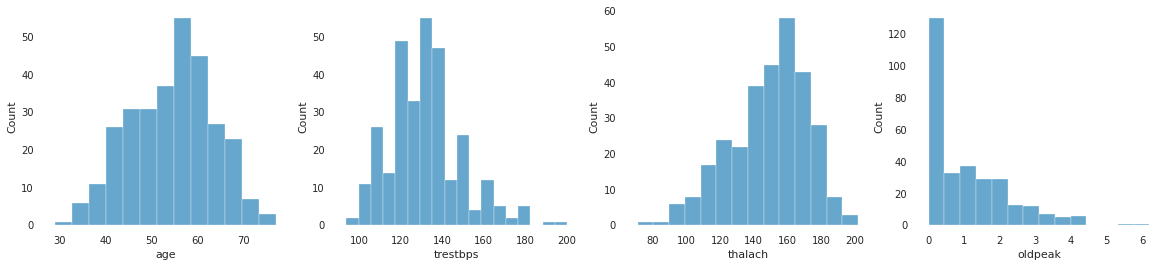

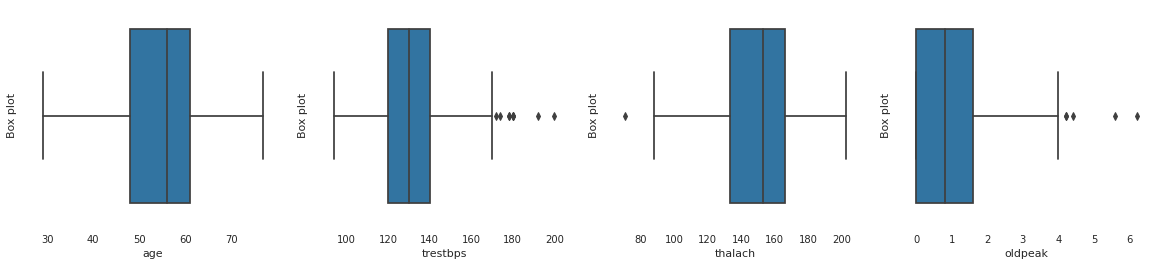

In [7]:
# Vẽ distributions của các biến numeric để xem scaler nào là phù hợp
numeric = ['age', 'trestbps', 'thalach', 'oldpeak']
categoric = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num']

len_numeric = len(numeric)
plt.figure(figsize=(20, 4))
for i, col in enumerate(numeric):
    plt.subplot(1, len_numeric, i+1)
    sb.histplot(data[col])
plt.figure(figsize=(20, 4))
for i, col in enumerate(numeric):    
    plt.subplot(1, len_numeric, i+1)
    sb.boxplot(data=data, x=col)
    plt.ylabel('Box plot')

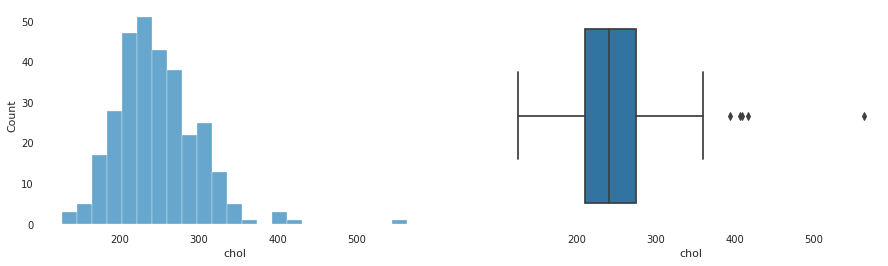

In [8]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
sb.histplot(data['chol']);
plt.subplot(1,2,2)
sb.boxplot(data=data, x='chol');

Vì các giá trị chỉ số Cholesterol > 400 là quá bất thường, nên loại các mẫu có Cholesterol > 400

In [9]:
data = data[data['chol']<400]

In [10]:
# Viết function pre-processing
def pre_processing(data, scaler, numeric_col=numeric, categoric_col=categoric, target_col=['chol'], one_hot=False):
    df_num = data[numeric_col]
    # One-hot
    if one_hot:
        df_cate = pd.get_dummies(data[categoric_col], columns=categoric_col, drop_first=True)
    else:
        df_cate = data[categoric_col]

    df_target = data[target_col]
    df = pd.concat([df_num, df_cate, df_target], axis=1)

    # Split train-test
    from sklearn.model_selection import train_test_split
    X = df.drop(columns=['chol'])
    y = df['chol']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Sử dụng Robust Scaler
    X_train[numeric] = scaler.fit_transform(X_train[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])

    return X_train, X_test, y_train, y_test

# Viết function SelectKbest để chọn các biến có tương quan tốt nhất tiến hành Features Selection.
def select_k_best_features(data, scaler, one_hot, threshold=1.0):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    X_train, X_test, y_train, y_test = pre_processing(data=data, scaler=scaler, one_hot=one_hot)

    best_k_features = SelectKBest(score_func=f_regression, k='all')
    best_k_features.fit(X_train, y_train)
    score = pd.Series(best_k_features.scores_)
    col = pd.Series(X_train.columns)
    result = pd.DataFrame({'Features': col, 'Score': score}).sort_values(by='Score', ascending=False)

    result = result[result['Score'] > threshold]
    print('SelectKBest - one_hot={}'.format(one_hot))
    display(result)
    features = result['Features'].to_list()
    return X_train[features], X_test[features], y_train, y_test

# Viết function FeatureImportance của Random Forest để chọn các biến có tương quan tốt nhất tiến hành Features Selection.
def feature_importance_rdn_forest(data, scaler, one_hot, threshold=0.02):
    from sklearn.ensemble import RandomForestRegressor
    X_train, X_test, y_train, y_test = pre_processing(data=data, scaler=scaler, one_hot=one_hot)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    score = pd.Series(model.feature_importances_)
    col = pd.Series(X_train.columns)
    result = pd.DataFrame({'Features': col, 'Score': score}).sort_values(by='Score', ascending=False)

    result = result[result['Score'] > threshold]
    print('FeaturesImportance by Random Forest - one_hot={}'.format(one_hot))
    display(result)
    features = result['Features'].to_list()
    return X_train[features], X_test[features], y_train, y_test

# Viết function sử dụng PCA, convert data thành các Principal Component, lựa chọn số lượng PC cho phù hợp để tạo data mới cho model
def pca_k_selection(data, scaler, one_hot, threshold=0.9):
    from sklearn.decomposition import PCA
    X_train, X_test, y_train, y_test = pre_processing(data=data, scaler=scaler, one_hot=one_hot)

    pca_n = PCA()
    P = pd.DataFrame(pca_n.fit_transform(X_train))
    result_pca = pd.DataFrame({'Dimension': np.arange(1,pca_n.n_components_ + 1),'Cum_ratio': np.cumsum(pca_n.explained_variance_ratio_)})
    result_pca = result_pca[result_pca['Cum_ratio'] <= threshold]
    print('PCA features selection - one_hot={}'.format(one_hot))
    display(result_pca)
    
    k = result_pca.iloc[-1, 0]
    pca = PCA(k)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=['PC_'+str(i) for i in range(1,k+1)])
    X_test = pd.DataFrame(X_test, columns=['PC_'+str(i) for i in range(1,k+1)])

    return X_train, X_test, y_train, y_test

In [11]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# 2 data_set không qua lựa chọn biến
data_set_1 = pre_processing(data, scaler, one_hot=False)
data_set_2 = pre_processing(data, scaler, one_hot=True)

# 2 data_set có lựa chọn biến bằng SelectKbest
data_set_3 = select_k_best_features(data, scaler, one_hot=False, threshold=2.0)
data_set_4 = select_k_best_features(data, scaler, one_hot=True, threshold=2.0)

# 2 data_set có lựa chọn biến bằng SelectKbest
data_set_5 = feature_importance_rdn_forest(data, scaler, one_hot=False, threshold=0.05)
data_set_6 = feature_importance_rdn_forest(data, scaler, one_hot=True, threshold=0.05)

# 2 data_set convert qua PCA
data_set_7 = pca_k_selection(data, scaler, one_hot=False, threshold=0.8)
data_set_8 = pca_k_selection(data, scaler, one_hot=True, threshold=0.8)

# Tạo list data-set:
list_data_set = [
            ('data full', data_set_1),
            ('data full - one_hot', data_set_2),
            ('data SelectKbest', data_set_3),
            ('data SelectKbest - one_hot', data_set_4),
            ('data rdn_forest', data_set_5),
            ('data rdn_forest - one_hot', data_set_6),
            ('data pca', data_set_7),
            ('data pca - one_hot', data_set_8),
]

SelectKBest - one_hot=False


,Features,Score
7,restecg,3.640513
4,sex,3.456151
1,trestbps,3.201535
0,age,2.642195
5,cp,2.292779


SelectKBest - one_hot=True


,Features,Score
24,num_2.0,3.703390
4,sex_1.0,3.456151
10,restecg_2.0,3.407115
1,trestbps,3.201535
0,age,2.642195
7,cp_4.0,2.621787
21,thal_6.0,2.273090


FeaturesImportance by Random Forest - one_hot=False


,Features,Score
0,age,0.200069
2,thalach,0.175776
1,trestbps,0.160918
3,oldpeak,0.136182
12,num,0.060385
10,ca,0.057431


FeaturesImportance by Random Forest - one_hot=True


,Features,Score
0,age,0.210368
2,thalach,0.185302
1,trestbps,0.151369
3,oldpeak,0.126487


PCA features selection - one_hot=False


,Dimension,Cum_ratio
0,1,0.433090
1,2,0.580532
2,3,0.670468
3,4,0.743718


PCA features selection - one_hot=True


,Dimension,Cum_ratio
0,1,0.232794
1,2,0.385766
2,3,0.479493
3,4,0.547138
4,5,0.602820
5,6,0.654937
6,7,0.703120
7,8,0.743027
8,9,0.778141


In [12]:
# - Tổng hợp các models đã liệt kê bên trên vào 1 list, hyper-parameter để default.
# - Viết function chạy Cross-validation 10-folds cho list models, xem kết quả ban đầu các models nào có hiệu quả cao, models nào hiệu quả thấp
# - Chọn ra 3 models hiệu quả nhất và tiến hành tuning hyper-parameters cho 3 models bằng Grid
# - Chạy lại kết quả list_models_best đã tuning, xem hiệu quả có được cải thiện, xem kết quả trên test set, chọn được model tốt nhất
# - Chạy lại cross-validation cho model vừa chọn trên full data để có kết quả so sánh với Openml.

In [13]:
# Tổng hợp các models đã liệt kê bên trên vào 1 list, hyper-parameter để default.
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, KFold

# Vì SVM poly được xem là model mạnh mẽ hơn Polynorminal thông thường, nên ở đây ta chỉ cần sử dụng SVM poly
list_model = [
              ('Linear Regression', LinearRegression()),
            #   ('KNN (3)', KNeighborsRegressor(3)),
              ('KNN (5)', KNeighborsRegressor(5)),
            #   ('KNN (8)', KNeighborsRegressor(8)),
              ('SVR - linear', SVR(kernel='linear')),
              ('SVR - poly 2', SVR(kernel='poly', degree=2)),
              ('SVR - poly 3', SVR(kernel='poly', degree=3)),
              ('SVR - rbf', SVR(kernel='rbf')),
              ('Random Forest', RandomForestRegressor(random_state=42)),
            #   ('AdaBoost', AdaBoostRegressor(base_estimator=RandomForestRegressor(random_state=42), random_state=42)),
            #   ('XGBoost', XGBRegressor()),
]

In [14]:
# Viết function chạy Cross-validation 5-folds cho list models, xem kết quả ban đầu các models nào có hiệu quả cao, models nào hiệu quả thấp.
def result_model_cv(list_model, data_set, cv_k=5, show_table=False):
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.model_selection import cross_validate, KFold
    from sklearn.metrics import mean_absolute_error

    data_name, data = data_set
    X_train, X_test, y_train, y_test = data

    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)
    result = []
    for name, model in list_model:
        cv_result = cross_validate(model, X_train, y_train, cv=kfold, return_train_score=True, scoring=['neg_mean_absolute_error', 'r2'])
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        result.append([data_name, name, 
                       np.abs(cv_result['train_neg_mean_absolute_error'].mean()), 
                       np.abs(cv_result['test_neg_mean_absolute_error'].mean()), 
                       cv_result['train_r2'].mean(),
                       cv_result['test_r2'].mean(),
                       cv_result['fit_time'].mean(),
                       cv_result['score_time'].mean(),
                       mean_absolute_error(y_train, y_pred_train),
                       mean_absolute_error(y_test, y_pred_test),
                       model.score(X_train, y_train),
                       model.score(X_test, y_test),
        ])

    result = pd.DataFrame(result, columns=['data_set', 'model', 'train_cv_mae', 'test_cv_mae',  
                                           'train_cv_r2', 'test_cv_r2', 'fit_time', 'score_time',
                                           'train_mae', 'test_mae', 'train_r2', 'test_r2',
                                           ])
    result.sort_values('test_cv_mae', ascending=True, inplace=True)
    if show_table:
        display(result)
    return result

In [15]:
list_result = []
for data_set in list_data_set:
    list_result.append(result_model_cv(list_model, data_set))
result = pd.concat(list_result, axis=0)
display(result.sort_values(['model', 'test_r2'], ascending=[True, False]))

,data_set,model,train_cv_mae,test_cv_mae,train_cv_r2,test_cv_r2,fit_time,score_time,train_mae,test_mae,train_r2,test_r2
1,data SelectKbest - one_hot,KNN (5),31.719209,38.667636,0.246905,-0.143796,0.001499,0.001702,31.964286,35.805333,0.245486,0.070698
1,data rdn_forest - one_hot,KNN (5),31.951225,39.674768,0.235170,-0.199257,0.001291,0.001641,31.294643,37.949333,0.241920,0.037261
1,data rdn_forest,KNN (5),32.927066,39.376545,0.208891,-0.149522,0.001310,0.001655,32.733036,39.253333,0.225587,-0.025238
1,data SelectKbest,KNN (5),31.103264,38.872162,0.260959,-0.171335,0.001268,0.001691,30.878571,38.738667,0.267841,-0.035601
1,data full - one_hot,KNN (5),31.679881,38.129596,0.256518,-0.091677,0.001692,0.002046,31.927679,36.290667,0.254054,-0.036135
1,data pca - one_hot,KNN (5),31.742591,38.171556,0.259105,-0.092761,0.001324,0.002103,30.888393,40.141333,0.294681,-0.142089
1,data pca,KNN (5),31.179345,38.087475,0.256639,-0.143439,0.001240,0.001575,30.500893,40.608000,0.288698,-0.167543
1,data full,KNN (5),31.703287,39.600040,0.246158,-0.154314,0.001351,0.001908,30.802679,40.066667,0.288939,-0.176957
0,data full,Linear Regression,35.023129,36.755132,0.076408,-0.031984,0.002161,0.001458,35.152191,33.244725,0.068757,0.135927
0,data pca - one_hot,Linear Regression,35.844164,37.142357,0.051744,-0.027523,0.001418,0.001202,35.976138,34.475299,0.046264,0.107700


Qua bảng kết quả chạy thử các model với parameter default, ta có thể thấy được:
- Model đơn gian nhất là Liearn Regression, tưởng chừng như đơn giản nhưng lại cho ra kết quả ổn định và tốt nhất trên test-set (r2 13.5%, data full, no one_hot).
- Nên thử Polynorminal bậc 2, 3 xem kết quả như thế nào.
- Hầu hết các model đều bị **Underfiting**, ngoại trừ model Random Forest nói riêng hay model về Tree nói chung. KNN cũng bị underfiting nhưng ít hơn (train-cv-r2 ~ 20%)
- Tuy nhiên model Random Forest bị **Overfiting**.
- Các model Underfiting, (ngoại trừ KNN) ở trong trường hợp này rất khó được cải thiện vì nó chỉ có train-r2 và test r2 <-5%.
- Vậy nên tập trung vào nhóm model Tree như **RandomForest, AdaBoost, XGBoost**, fine-tunning model để cải thiện **Overfitting**.
- Thử xử lý **Underfitting** cho model **KNN**, lựa chọn k của KNN cho phù hợp
- Về nhóm data-set phù hợp với model Tree. Vì model Tree có đặc tính tốt khi phân loại các features nên không cần thiết sử dụng features selection, đồng thời kết quả cũng cho thấy kết quả giữa các data_set cho model Random Forest không mang lại sự khác biệt nhiều.

In [16]:
X_train, X_test, y_train, y_test = data_set_1
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print('R2 Train - Linear: {:.4f}'.format(linear_model.score(X_train, y_train)))
print('R2 Test - Linear: {:.4f}'.format(linear_model.score(X_test, y_test)))

R2 Train - Linear: 0.0688
R2 Test - Linear: 0.1359


In [17]:
from sklearn.preprocessing import PolynomialFeatures
X_train, X_test, y_train, y_test = data_set_1

poly_2 = PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_2.fit_transform(X_train)
X_test = poly_2.transform(X_test)

poly_model_2 = LinearRegression()
poly_model_2.fit(X_train, y_train)
print('R2 Train - Poly 2: {:.4f}'.format(poly_model_2.score(X_train, y_train)))
print('R2 Test - Poly 2: {:.4f}'.format(poly_model_2.score(X_test, y_test)))

R2 Train - Poly 2: 0.4909
R2 Test - Poly 2: -1.0863


In [18]:
from sklearn.preprocessing import PolynomialFeatures
X_train, X_test, y_train, y_test = data_set_1

poly_3 = PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_3.fit_transform(X_train)
X_test = poly_3.transform(X_test)

poly_model_3 = LinearRegression()
poly_model_3.fit(X_train, y_train)
print('R2 Train - Poly 3: {:.4f}'.format(poly_model_3.score(X_train, y_train)))
print('R2 Test - Poly 3: {:.4f}'.format(poly_model_3.score(X_test, y_test)))

R2 Train - Poly 3: 1.0000
R2 Test - Poly 3: -15.7146


- Dường như Linear model ngẫu nhiên phù hợp với test-set đã được chia so với các model mạnh khác.
- Thử sử dụng Polynorminal thì model bị overfiting.
- Sẽ thử sử dụng SVM - poly 2,3 sau khi fine-tuning để xem có thể cải thiện được không.
- Trước hết là tunning model Random Forest

In [19]:
# Thử fine-tunning model Random Forest bằng ccp_alphas
def display_regr_tree_pruning_cv_result(ccp_alphas, X, y, cv_k=5, rdn_forest=True):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import cross_validate, KFold

    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)
    train_r2 = []
    test_r2 = []
    train_mae = []
    test_mae = []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        if rdn_forest:
            regr_tree = RandomForestRegressor(ccp_alpha=ccp_alpha, random_state=42)
        else:
            regr_tree = DecisionTreeRegressor(ccp_alpha=ccp_alpha, random_state=42)
        score = cross_validate(regr_tree, X, y, cv=kfold, scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)

        # Append result mean r2, mae
        train_r2.append(np.mean(score['train_r2']))
        test_r2.append(np.mean(score['test_r2']))
        train_mae.append(np.mean(np.abs(score['train_neg_mean_absolute_error'])))
        test_mae.append(np.mean(np.abs(score['test_neg_mean_absolute_error'])))

    # Wrap to numpy array to for easy to manipulate
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    train_mae = np.array(train_mae)
    test_mae = np.array(test_mae)

    k = test_mae.argmin()
    k_f_bound = len(test_mae)-1-k
    k_f = k + k_f_bound
    k_b = k - k
    ccp_alphas_optimal = ccp_alphas[k]

    if rdn_forest:
        optimal_regr_tree = RandomForestRegressor(random_state=42, ccp_alpha=ccp_alphas[k]).fit(X, y)
    else:
        optimal_regr_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alphas[k]).fit(X, y)

    # Visualize
    plt.figure(figsize=(16,6))

    plot_1 = plt.subplot(1,2,1)
    plt.plot(ccp_alphas[k_b:k_f], train_r2[k_b:k_f], drawstyle='steps-post', label='train R2')
    plt.plot(ccp_alphas[k_b:k_f], test_r2[k_b:k_f], label='test R2')
    plt.plot(ccp_alphas[k], test_r2[k], 'ro', label='Max test R2: {:.4f} at alpha: {:.4f}'.format(test_r2[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('R2')
    plt.legend()
    plt.title('R2 test-cv')

    plot_2 = plt.subplot(1,2,2)
    plt.plot(ccp_alphas[k_b:k_f], train_mae[k_b:k_f], drawstyle='steps-post', label='train MAE')
    plt.plot(ccp_alphas[k_b:k_f], test_mae[k_b:k_f], label='test MAE')
    plt.plot(ccp_alphas[k], test_mae[k], 'ro', label='Min test MAE: {:.4f} at alpha: {:.4f}'.format(test_mae[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('MAE test-cv')

    plt.show()
    return optimal_regr_tree, ccp_alphas_optimal

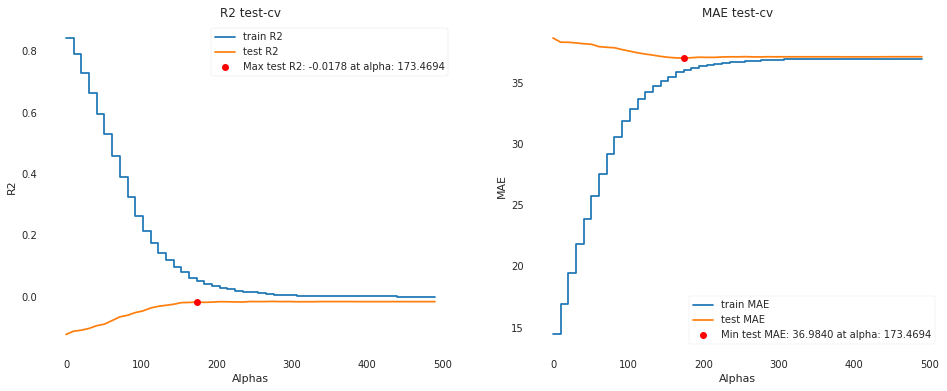

R2 Train: 0.0155
R2 Test: 0.0149


In [20]:
ccp_alphas_cv = np.linspace(0,500,50)
X_train, X_test, y_train, y_test = data_set_2
optimal_regr_tree, ccp_alphas_optimal = display_regr_tree_pruning_cv_result(ccp_alphas_cv, X_train, y_train, rdn_forest=True)
print('R2 Train: {:.4f}'.format(optimal_regr_tree.score(X_train, y_train)))
print('R2 Test: {:.4f}'.format(optimal_regr_tree.score(X_test, y_test)))

- Qua kết quả cho thấy việc tunning Random Forest cũng không hiệu quả.
- Thử sử dụng AdaBoost, XGBoost

In [21]:
ada_model = AdaBoostRegressor(base_estimator=optimal_regr_tree, n_estimators=100, learning_rate=0.1, random_state=42)
ada_model.fit(X_train, y_train)
print('R2 Train: {:.4f}'.format(ada_model.score(X_train, y_train)))
print('R2 Test: {:.4f}'.format(ada_model.score(X_test, y_test)))

R2 Train: 0.2644
R2 Test: 0.0573


In [22]:
xgboost = XGBRegressor(base_estimator=optimal_regr_tree, n_estimators=50, learning_rate=0.5, random_state=42)
xgboost.fit(X_train, y_train)
print('R2 Train: {:.4f}'.format(xgboost.score(X_train, y_train)))
print('R2 Test: {:.4f}'.format(xgboost.score(X_test, y_test)))

[17:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 Train: 0.9170
R2 Test: -0.2195


- Random Forest sau khi tunning bằng ccp_alphas vẫn cho kết quả rất thấp.
- Dường như đồ thị cho thấy model Random Forest hay Tree nói chung rất khó để generalize từ train sang test.
- Thử tiến hàng find-tuning 1 loạt model bằng Grid xem kết quả ra sao

In [23]:
# Thử tiến hành fine-tuning all model bằng Grid
model_tunning_list = [
            #   ('Linear Regression', LinearRegression()),
              ('KNN', KNeighborsRegressor()),
              ('SVR - linear', SVR(kernel='linear')),
              ('SVR - poly 2', SVR(kernel='poly', degree=2)),
              ('SVR - poly 3', SVR(kernel='poly', degree=3)),
              ('SVR - rbf', SVR(kernel='rbf')),
              ('Random Forest', RandomForestRegressor(random_state=42)),
              ('AdaBoost', AdaBoostRegressor(base_estimator=optimal_regr_tree, random_state=42)),
            #   ('GradientBoost', GradientBoostingRegressor(random_state=42)),
              ('XGBoost', XGBRegressor(base_estimator=optimal_regr_tree, random_state=42)),
]
param_grid_knn = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
            }

param_grid_svr_linear = {'C': [1, 10, 20, 30, 50, 100],
            }

param_grid_svr_poly2 = {'C': [1, 10, 20, 30, 50, 100],
              'gamma': ['scale', 'auto', 0.1, 0.01, 0.005, 0.001],
            }

param_grid_svr_poly3 = {'C': [1, 10, 20, 30, 50, 100],
              'gamma': ['scale', 'auto', 0.1, 0.01, 0.005, 0.001],
            }

param_grid_svr_rbf = {'C': [1, 10, 20, 30, 50, 100],
              'gamma': ['scale', 'auto', 0.1, 0.01, 0.005, 0.001],
            }

param_grid_rdn_forest = {'n_estimators': [50, 100, 200, 300],
              'criterion': ['mae'],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [1, 2, 3, 4],
            }

param_grid_ada_boost = {'n_estimators': [20, 30, 50, 100],
              'learning_rate': [0.001, 0.005, 0.01, 0.1],
            }

param_grid_xg_boost = {'n_estimators': [20, 30, 50, 100],
              'learning_rate': [0.001, 0.005, 0.01, 0.1],
            }


params = [param_grid_knn,
          param_grid_svr_linear,
          param_grid_svr_poly2,
          param_grid_svr_poly3,
          param_grid_svr_rbf,
          param_grid_rdn_forest,
          param_grid_ada_boost,
          param_grid_xg_boost,
]

In [24]:
# Viết function tuning hyper-parameters models bằng Grid
def rename_keys(dic, pattern):
    return dict([(keys.split(pattern)[1], values) for keys, values in dic.items()])

def process_tunning_model(model_tunning_list, params, X, y, scoring='neg_mean_absolute_error', cv_k=5):
    from sklearn.model_selection import GridSearchCV, KFold
    import time
    models_final = []
    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)

    for model_list, param in zip(model_tunning_list, params):
        tic = time.time()
        model_name, model = model_list
        search = GridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring=scoring)
        search.fit(X, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} have been tunned in {:,.2f} seconds'.format(model_name, (toc-tic)))
    return models_final

In [25]:
X_train, X_test, y_train, y_test = data_set_2
models_final = process_tunning_model(model_tunning_list, params, X_train, y_train, scoring='neg_mean_absolute_error')
models_final

Model KNN have been tunned in 0.19 seconds
Model SVR - linear have been tunned in 0.35 seconds
Model SVR - poly 2 have been tunned in 1.09 seconds
Model SVR - poly 3 have been tunned in 1.08 seconds
Model SVR - rbf have been tunned in 1.25 seconds
Model Random Forest have been tunned in 40.85 seconds
Model AdaBoost have been tunned in 736.36 seconds
[17:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:23] WA

[('KNN',
  KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                      weights='uniform')),
 ('SVR - linear',
  SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
      kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
 ('SVR - poly 2',
  SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.001,
      kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
 ('SVR - poly 3',
  SVR(C=30, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
      kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
 ('SVR - rbf',
  SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.005,
      kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
 ('Random Forest',
  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                        max

In [26]:
result_model_cv(models_final, list_data_set[1])

[17:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:52:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,data_set,model,train_cv_mae,test_cv_mae,train_cv_r2,test_cv_r2,fit_time,score_time,train_mae,test_mae,train_r2,test_r2
1,data full - one_hot,SVR - linear,34.718472,36.596959,0.052912,-0.020033,0.003718,0.001497,34.846545,34.963206,0.050684,0.053737
4,data full - one_hot,SVR - rbf,34.665656,36.611157,0.056380,-0.018137,0.005011,0.001691,34.784093,35.059123,0.053457,0.051846
5,data full - one_hot,Random Forest,33.344359,36.675191,0.140716,-0.011263,0.079525,0.004723,34.000357,35.579600,0.112225,0.041031
6,data full - one_hot,AdaBoost,34.947406,36.864148,0.105739,-0.011534,5.621686,0.184380,36.039880,35.814254,0.047521,0.042079
3,data full - one_hot,SVR - poly 3,29.452383,36.878491,0.209783,-0.027318,0.004897,0.001606,29.627102,36.751954,0.203012,-0.043066
2,data full - one_hot,SVR - poly 2,36.777674,37.157782,-0.008490,-0.026888,0.003661,0.001542,36.813340,36.734640,-0.007544,-0.006231
0,data full - one_hot,KNN,31.940865,38.006633,0.225182,-0.095886,0.002081,0.002354,31.868304,35.602222,0.224984,0.013644
7,data full - one_hot,XGBoost,28.926579,38.168852,0.320266,-0.131572,0.012710,0.001833,30.165356,36.843039,0.273640,-0.032929


- Sau khi tunning các models bằng Grid, kết quả models vẫn rất tệ
- Thử sử dụng Voiting Regressor

In [27]:
from sklearn.ensemble import VotingRegressor
model = VotingRegressor(estimators=models_final)
X_train, X_test, y_train, y_test = data_set_2
model.fit(X_train, y_train)
print('R2 Train: {:.4f}'.format(model.score(X_train, y_train)))
print('R2 Test: {:.4f}'.format(model.score(X_test, y_test)))

[17:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 Train: 0.1617
R2 Test: 0.0529


- Kết quả vẫn không được cải thiện.
- Thử sử dụng models neuron net đơn giản

In [28]:
X_train, X_test, y_train, y_test = data_set_2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Model
n = 50
input = Input(shape=(X_train.shape[1],))
x = Dense(n)(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(n)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(n)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(n)(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='relu')(x)
model = Model(inputs=[input], outputs=[output])

model.compile(loss='mae', optimizer=keras.optimizers.Adamax(lr=0.01))

checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint_cb], verbose=2)
model.evaluate(X_test, y_test)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score
print('')
print('Final Result by Neuron Net model:')
print('R2 train: {:.4f}'.format(r2_score(y_train, y_pred_train)))
print('R2 test: {:.4f}'.format(r2_score(y_test, y_pred_test)))
print('MAE train: {:.4f}'.format(mean_absolute_error(y_train, y_pred_train)))
print('MAE test: {:.4f}'.format(mean_absolute_error(y_test, y_pred_test)))

Epoch 1/100
7/7 - 1s - loss: 238.2542 - val_loss: 240.0804
Epoch 2/100
7/7 - 0s - loss: 222.5405 - val_loss: 233.9709
Epoch 3/100
7/7 - 0s - loss: 199.0363 - val_loss: 222.8069
Epoch 4/100
7/7 - 0s - loss: 165.5863 - val_loss: 204.2917
Epoch 5/100
7/7 - 0s - loss: 118.0912 - val_loss: 178.1526
Epoch 6/100
7/7 - 0s - loss: 68.7582 - val_loss: 143.4177
Epoch 7/100
7/7 - 0s - loss: 48.4137 - val_loss: 120.7373
Epoch 8/100
7/7 - 0s - loss: 46.6404 - val_loss: 124.6739
Epoch 9/100
7/7 - 0s - loss: 35.7569 - val_loss: 135.8521
Epoch 10/100
7/7 - 0s - loss: 34.6010 - val_loss: 131.1293
Epoch 11/100
7/7 - 0s - loss: 34.0978 - val_loss: 122.2237
Epoch 12/100
7/7 - 0s - loss: 31.4601 - val_loss: 115.6873
Epoch 13/100
7/7 - 0s - loss: 32.0448 - val_loss: 107.7811
Epoch 14/100
7/7 - 0s - loss: 28.9805 - val_loss: 105.5140
Epoch 15/100
7/7 - 0s - loss: 27.8552 - val_loss: 103.6123
Epoch 16/100
7/7 - 0s - loss: 28.4576 - val_loss: 94.5933
Epoch 17/100
7/7 - 0s - loss: 28.5101 - val_loss: 90.2711
Epo

- Kết quả vẫn neuron network khá tệ.
- Kết luận data set này khó quá. hihi
- Thử dùng **unsupervised learning** để phân nhóm dựa trên input. Rồi tiến hành regression dựa trên từng nhóm, và tổng hợp kết quả.

In [29]:
# Viết function plot elbow chart cho KMeans
def plot_elbow_chart_KMeans(X, start=1, stop=20):
    from sklearn.cluster import KMeans
    k_means_list = []
    for i in range(start, stop+1):
        model = KMeans(n_clusters=i)
        model.fit(X)
        k_means_list.append([i, model.inertia_])

    k_means_result = pd.DataFrame(k_means_list, columns=['k', 'SS_distances'])
    plt.plot(k_means_result['k'], k_means_result['SS_distances'], 'x-')
    plt.title('The Elbow Method for chosing optimal k')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.xticks(np.arange(start, stop+1))
    plt.show()
    return k_means_result

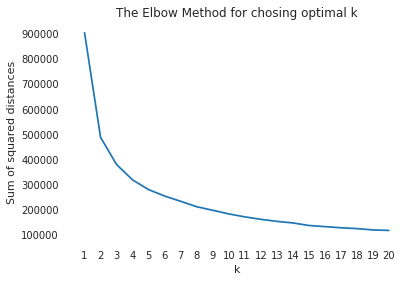

In [30]:
X_train, X_test, y_train, y_test = data_set_1
k_means_result = plot_elbow_chart_KMeans(data)

- Kết quả cho thấy khá là khó để data phân loại nhóm cho phù hợp.

In [31]:
data.corr()['chol'].sort_values()

sex        -0.142546
thal       -0.027325
slope      -0.022987
thalach    -0.021044
fbs         0.000771
oldpeak     0.005260
cp          0.067444
num         0.069012
exang       0.086233
ca          0.103711
restecg     0.134874
trestbps    0.150791
age         0.178587
chol        1.000000
Name: chol, dtype: float64

- Dựa trên correlation, chọn 2 biến có tương quan lớn nhất là age và trestbps.
- Thử phân loại unsupervised learning trên 2 biến vừa chọn

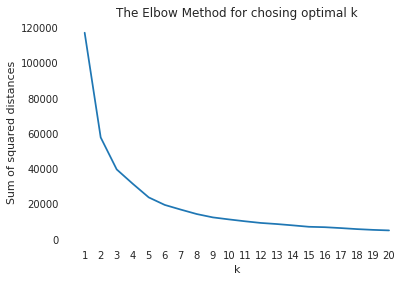

In [32]:
k_means_result = plot_elbow_chart_KMeans(data[['age', 'trestbps']])

In [33]:
def plot_cluster_result_KMeans_2_features(X, y, optimal_k):
    from sklearn.cluster import KMeans
    model = KMeans(n_clusters=optimal_k)
    model.fit(X)
    label = model.labels_
    centroid = model.cluster_centers_
    # Plot scatter with clustered and centroid of all cluster group
    plt.figure(figsize=(10,6))
    sb.scatterplot(data=X, x=X.columns[0], y=X.columns[1], hue=label, s=y);
    plt.title('Total sum of squares within-cluster: {:.2f}'.format(model.inertia_))
    num_centroid = centroid.shape[0]
    for i in range(num_centroid):
        plt.scatter(centroid[i, 0], centroid[i, 1], s=80, label='Centroid {}'.format(i))
        plt.legend()

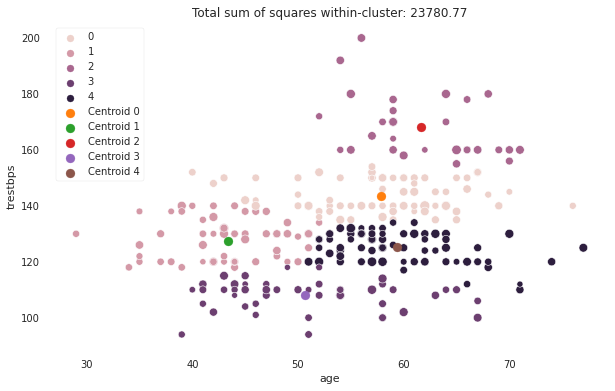

In [34]:
plot_cluster_result_KMeans_2_features(data[['age', 'trestbps']], data['chol']/4, 5)

- Thử phân loại bằng các biến numeric hay categoric, so sánh nhóm tương quan sau khi phân loại đều không có phân cụm rõ ràng so với biến target 'chol'.
- Điều này cho thấy nếu sử dụng Unsupervised learning thì vẫn không thể cải thiện được kết quả.

**Kết luận:**
- Sau khi thử qua rất nhiều model, tunning hyper-parameter, hầu hết các model đều đưa ra kết quả rất tệ trên test-set của Cross-validation.
- Điều này cho thấy các model không thể generalize từ train -> test để đưa ra kết quả tốt cho dữ liệu chưa train.
- Việc chia train-test split theo random_state = 42, thì model Linear Regression đem lại kết quả tốt nhất trên test set, mặc dù điều này không thể nói lên được là model Linear sẽ hoạt động hiệu quả trên các mẫu chưa được train trong thực tế (future-test set).
- Dưới đây là kết quả Linear Regression, MAE = 34.67 trên full data, MAE cross validation 5-folds = 36.7
- So sánh với kết quả tốt nhất của Openml là MAE 39.0, kết quả model tìm ra tốt hơn trên Openml.
- MAE tốt hơn kết quả của Openml nhưng R2 đạt được quá nhỏ ~ 10% nên model vẫn không thể sử dụng thực tế trong y khoa.

In [35]:
X_train, X_test, y_train, y_test = data_set_1
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)
y_full = pd.concat([y_train, y_test], axis=0)
y_pred_full = np.concatenate([y_pred_train, y_pred_test], axis=0)

from sklearn.metrics import mean_absolute_error, r2_score
print('R2 Train - Linear: {:.4f}'.format(linear_model.score(X_train, y_train)))
print('R2 Test - Linear: {:.4f}'.format(linear_model.score(X_test, y_test)))
print('MAE train: {:.4f}'.format(mean_absolute_error(y_train, y_pred_train)))
print('MAE test: {:.4f}'.format(mean_absolute_error(y_test, y_pred_test)))
print('MAE full: {:.4f}'.format(mean_absolute_error(y_full, y_pred_full)))

R2 Train - Linear: 0.0688
R2 Test - Linear: 0.1359
MAE train: 35.1522
MAE test: 33.2447
MAE full: 34.6737


**Đề xuất**:
- Trong thực tế y khoa, kết quả đo chol chỉ là để chỉ ra được cholesterol **bình thường **(<200mg/dl), **cao giới hạn** (200-239mg/dl) hay **cao** (>240mg/dl). (nguồn: http://viendinhduong.vn/vi/dinh-duong-tiet-che/nhung-dieu-can-biet-ve-cholesterol-mau.html)
- Ví dụ: nếu chỉ số chol 180mg/dl mà model predict ra 195mg/dl hay 170mg/dl thì đều thuộc nhóm bình thường (<200mg/dl), nên việc thực hiện Regression để chỉ ra chính xác bao nhiêu mg/dl là **không quan trọng bằng việc xác định mức chol ở nhóm nào trong 3 nhóm kể trên**, để từ đó đưa ra các kết luận về bệnh lý có liên quan.
- Vậy nên thay về thực hiện Regression, ta sẽ chia lại chỉ số chol vào 3 nhóm trên và tiến hành xây dựng model về **Classification**.
- Ta sẽ tiến hành xây dựng model Classification trong notebook 2.